# DNN Model

In [270]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [271]:
# data loading from .npz generated from tcr_data_process.ipynb
# loading train data
npz = np.load('data_train.npz')
train_inputs = npz['input'].astype(np.float64)
train_targets = npz['targets'].astype(np.float64)
# loading validation data
npz = np.load('data_validation.npz')
validation_inputs, validation_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

npz = np.load('data_test.npz')
test_inputs, test_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

# ANN Model

Outline, Optimizer, Loss function, Early stopping and Training rate

In [272]:
# NN model prep
input_size = 19
output_size = 1
hidden_layer_1_size = 50
hidden_layer_2_size = 50
hidden_layer_3_size = 25

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size),
    tf.keras.layers.Dense(hidden_layer_1_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_2_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_3_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='sigmoid'),
])


In [273]:
# model prep, optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])



In [274]:
# Training
BATCH_SIZE = 1
MAX_EPOCHS = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [275]:
# fit the model
history = model.fit(
    train_inputs, train_targets, batch_size=BATCH_SIZE,epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(validation_inputs, validation_targets), verbose=2
          )

Epoch 1/1000
102/102 - 7s - loss: 0.3104 - root_mean_squared_error: 0.5571 - val_loss: 0.2962 - val_root_mean_squared_error: 0.5442 - 7s/epoch - 72ms/step
Epoch 2/1000
102/102 - 1s - loss: 0.2972 - root_mean_squared_error: 0.5451 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5318 - 812ms/epoch - 8ms/step
Epoch 3/1000
102/102 - 1s - loss: 0.2844 - root_mean_squared_error: 0.5333 - val_loss: 0.2703 - val_root_mean_squared_error: 0.5199 - 1s/epoch - 11ms/step
Epoch 4/1000
102/102 - 1s - loss: 0.2721 - root_mean_squared_error: 0.5217 - val_loss: 0.2580 - val_root_mean_squared_error: 0.5080 - 629ms/epoch - 6ms/step
Epoch 5/1000
102/102 - 1s - loss: 0.2602 - root_mean_squared_error: 0.5101 - val_loss: 0.2464 - val_root_mean_squared_error: 0.4964 - 736ms/epoch - 7ms/step
Epoch 6/1000
102/102 - 1s - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2350 - val_root_mean_squared_error: 0.4848 - 836ms/epoch - 8ms/step
Epoch 7/1000
102/102 - 1s - loss: 0.2372 - root_mean_squared_e

In [276]:
# ANN model summary
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (1, 19)                   380       
                                                                 
 dense_87 (Dense)            (1, 50)                   1000      
                                                                 
 dense_88 (Dense)            (1, 50)                   2550      
                                                                 
 dense_89 (Dense)            (1, 25)                   1275      
                                                                 
 dense_90 (Dense)            (1, 1)                    26        
                                                                 
Total params: 5,231
Trainable params: 5,231
Non-trainable params: 0
_________________________________________________________________


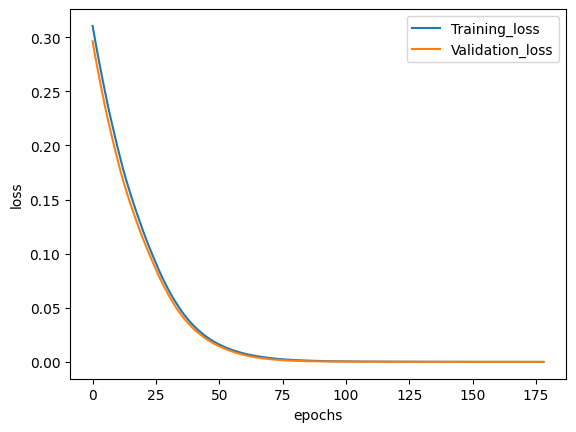

In [277]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Model check on Test data

In [278]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

1/1 [==============================] - 1s 743ms/step - loss: 1.1090e-05 - root_mean_squared_error: 0.0033


In [279]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f} rmse'.format(test_loss, test_accuracy))


Test loss: 0.0000. Test accuracy: 0.0033 rmse


In [280]:
prediction = model.predict(test_inputs)
data_inputs = pd.DataFrame(test_inputs)
prediction = pd.DataFrame(prediction)
test_targets = pd.DataFrame(test_targets)
pred_accu = (prediction/test_targets)*100

result = pd.concat([test_targets, prediction, pred_accu], axis = 1, ignore_index=True)
result.columns = ['Target-St(%)', 'Prediction-St(%)','Pred-Accu-St(%)']
result

1/1 [==============================] - 0s 300ms/step


,Target-St(%),Prediction-St(%),Pred-Accu-St(%)
0,0.97,0.968332,99.828071
1,0.98,0.977954,99.791191
2,0.99,0.983549,99.348414
3,0.99,0.988595,99.858070
4,0.99,0.987193,99.716488
5,0.94,0.940383,100.040740
6,0.97,0.971012,100.104286
7,1.00,0.992195,99.219531
8,0.98,0.980571,100.058299
9,0.99,0.987193,99.716488


Text(0.5, 0, 'Targets (red) & Predictions (blue)')

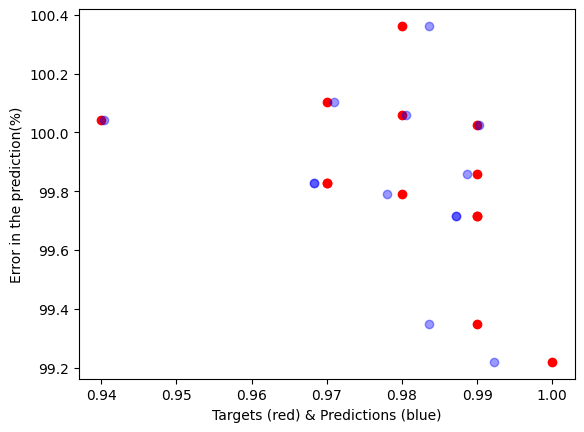

In [286]:
plt.scatter(result['Target-St(%)'], result['Pred-Accu-St(%)'], color='r')
plt.scatter(result['Prediction-St(%)'], result['Pred-Accu-St(%)'],alpha=0.4, color='b')
plt.ylabel('Error in the prediction(%)')
plt.xlabel('Targets (red) & Predictions (blue)')


In [282]:
# estimation of R2 score
from sklearn.metrics import r2_score
r2_score_test = r2_score(test_targets, prediction)
r2_score_test

0.9485129994616072

In [283]:
# estimation of adjusted R2 score
n = np.size(test_targets)
k = 3 # number of features
adj_r2_score = 1 - (((1-r2_score_test)*(n-1))/((n-k-1)))
adj_r2_score

0.9313506659488096

In [284]:
mean_pred = pred_accu.mean()
std_pred = pred_accu.std()
uncertainty_model = std_pred
print("Uncertainty of the ANN model:", np.round(uncertainty_model[0],2), '[%]')
print("Average test prediction precision", np.round(100 - uncertainty_model[0],2), '[%]')

Uncertainty of the ANN model: 0.31 [%]
Average test prediction precision 99.69 [%]


# ANN Model Deployment

ANN model deployment for micro DSC error prediction

In [285]:
import keras
model.save('micro_dsc_dl.h5')